In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectFromModel

# Load pandas
import pandas as pd

# Load numpy
import numpy as np

# Load feature extraction module
from spc_extractFeatures import *

# Load glob, os, random
import glob
import os
import random
import caffe
import pickle
DEBUG = False
import matplotlib.pyplot as plt
import itertools
import joblib
import csv
import timeit

/data4/plankton_wi17/mpl/python/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/data4/plankton_wi17/mpl/python/local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


In [3]:
def train_testSplit(domain, srcPath):
    assert isinstance(domain, str) # options limited to spcbench, spcinsitu, spcombo
    trainPartition = 0.70
    train_fns = []; train_lbls = []
    print domain + ' selected'
    if domain == 'spcbench':
        destPath = '/data4/plankton_wi17/mpl/source_domain/spcbench/bench_ensemble'
        train_fns, train_lbls = getFnsAndLbls(srcPath + '/train.txt', Target=False)
        val_fns, val_lbls = getFnsAndLbls(srcPath + '/val.txt', Target=False)
    elif domain == 'spcinsitu':
        destPath = '/data4/plankton_wi17/mpl/source_domain/spcinsitu/insitu_ensemble'
        train_fns, train_lbls = getFnsAndLbls(srcPath + '/train.txt', Target=False)
        val_fns, val_lbls = getFnsAndLbls(srcPath + '/val.txt', Target=False)
    elif domain == 'spcombo':
        destPath = '/data4/plankton_wi17/mpl/source_domain/spcombo/combo_ensemble'
        train_fns, train_lbls = getFnsAndLbls(srcPath + '/train.txt', Target=False)
        val_fns, val_lbls = getFnsAndLbls (srcPath + '/val.txt', Target=False)

    testFile = '/data4/plankton_wi17/mpl/target_domain/aspect_target_image_path_labels.txt'
    test_fns, test_lbls = getFnsAndLbls(testFile, Target=True)

    train_fns, train_lbls = randomize_writepaths(train_fns, train_lbls, 'train', destPath)
    val_fns, val_lbls = randomize_writepaths (val_fns, val_lbls, 'val', destPath)
    test_fns, test_lbls = randomize_writepaths(test_fns, test_lbls, 'test', destPath)
    
    train = {'imgs': train_fns, 'lbls': train_lbls}
    val = {'imgs': val_fns, 'lbls': val_lbls}
    test = {'imgs': test_fns, 'lbls': test_lbls}
    return train, val, test

def getFnsAndLbls(textFile, Target=True):
    try:
        if Target:
            df = pd.read_csv(textFile, delimiter=';', names=['img','id', 'lbl'])
        else:
            df = pd.read_csv(textFile, delimiter=' ', names=['img', 'lbl'])
    except:
        print "Check text file formatting"
    test_fns = df['img'].tolist()
    test_lbls = np.array(df['lbl'].tolist())
    return test_fns, test_lbls

def randomize_writepaths(fns, lbs, key, dest_path):
    '''
    Randomize images and labels
    :param fns: list of file names
    :param lbs: list of labels
    :param key: str like train, val, or text
    :param dest_path: path to write text file of all files and labels randomized
    :return: shuffled files and labels
    '''

    # Shuffle fns and labels
    index = range (len (fns))
    random.shuffle (index)
    fns = [fns[i] for i in index]
    lbs = np.array ([lbs[i] for i in index])

    # Write img and labels to text file
    with open (dest_path + '/{}.txt'.format (key), "w") as f:
        for i in range (len (fns)):
            f.write (str (fns[i]) + ' ' + str (lbs[i]) + '\n')
    f.close ()
    return fns, lbs

def extractFeature(imgList, featureName):
    st = timeit.default_timer()
    if not os.path.exists(featureName):
        print "Extracting Features for {} \n".format(featureName)
        numFeatures = 72
        featureVector = np.zeros([len(imgList), numFeatures])
        for i, imgname in enumerate(imgList):
            img = caffe.io.load_image (imgname)
            img = caffe.io.resize_image(img, [256,256])
            img = (img * 255).astype (np.uint8)
            featureVector[i,:] = extractFeatures(img)
            if i%100 == 0:
                #print i,'/',len(imgList),'remaining ETA:',(timeit.default_timer() - st) / ()
                print '%d remaining, ETA: %f' %(len(imgList) - i, (timeit.default_timer() - st)/(i+1) * (len(imgList) - i))
        joblib.dump(featureVector, featureName)
    else:
        featureVector = joblib.load(featureName)
    print featureName + ' loaded \n'
    return featureVector

# Set up datasets

Split data into training, validation, & test

In [10]:
t1 = timeit.default_timer()
EXP_NUM = 'exp1'
idx = 1
DOMAIN = ['spcbench',
          'spcinsitu',
          'spcombo']
CLASSIFIER_NAME = '{}_ensemble'.format(DOMAIN[idx].strip('spc'))
SRCPATH = [#'/data4/plankton_wi17/mpl/source_domain/spcombo/combo_images_exp',
           '/data4/plankton_wi17/mpl/source_domain/spcbench/bench_finetune/code',
           '/data4/plankton_wi17/mpl/source_domain/spcinsitu/insitu_finetune/code',
           '/data4/plankton_wi17/mpl/source_domain/spcombo/combo_finetune/all-noise100/all-noise100_100-100/code']

train, val, test = train_testSplit(DOMAIN[idx], SRCPATH[idx])
# verifylbl = np.asarray(zip(train['imgs'][:2],train['lbls'][:2]))
datasets = {'train':train, 'val':val, 'test':test}
for key,i in datasets.iteritems():
    print key
    unique, counts = np.unique(i['lbls'], return_counts=True)
    print(np.asarray(zip(unique,counts)))

spcinsitu selected
test
[[    0  2720]
 [    1 23049]]
train
[[   0 1649]
 [   1 2382]]
val
[[  0 235]
 [  1 341]]


In [ ]:
trainFeatures = extractFeature(train['imgs'], 'imgFeatures/{}_trainFeatures'.format(DOMAIN[idx]))
valFeatures = extractFeature (val['imgs'], 'imgFeatures/{}_valFeatures'.format (DOMAIN[idx]))
testFeatures = extractFeature(test['imgs'], 'imgFeatures/targetFeatures')

Extracting Features for imgFeatures/spcinsitu_trainFeatures 



/data4/plankton_wi17/mpl/python/lib/python2.7/scikit-image/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/data4/plankton_wi17/mpl/python/lib/python2.7/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/data4/plankton_wi17/mpl/python/lib/python2.7/scikit-image/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSA

0 / 4031
100 / 4031
200 / 4031
300 / 4031
400 / 4031
500 / 4031
600 / 4031
700 / 4031
800 / 4031
900 / 4031
1000 / 4031
1100 / 4031
1200 / 4031
1300 / 4031
1400 / 4031
1500 / 4031
1600 / 4031
1700 / 4031
1800 / 4031
1900 / 4031
2000 / 4031
2100 / 4031
2200 / 4031
2300 / 4031
2400 / 4031
2500 / 4031


In [8]:
#clf1 = RandomForestClassifier (n_estimators=400, min_samples_split=45, max_features=15,
#                               max_depth=50,random_state=0, oob_score=True, n_jobs=-1)
#clf1 = RandomForestClassifier (n_estimators=301, max_depth=7, max_features=19, random_state=0, n_jobs=-1)
#clf1 = RandomForestClassifier (n_estimators=400, max_depth=10, max_features='sqrt', random_state=0, n_jobs=-1)  # exp2 1-29-18 
clf1 = RandomForestClassifier (random_state=0, n_jobs=-1)

clf1.fit (trainFeatures, train['lbls'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [9]:
preds = clf1.predict(valFeatures)
gtruth = np.array(val['lbls'])
totalAccu = np.equal(preds,gtruth).mean()*100
errorRate = (preds != gtruth).mean() * 100
num_class = 2
# Create array for confusion matrix with dimensions based on number of classes
confusion_matrix_rawcount = np.zeros ((num_class, num_class))
class_count = np.zeros((num_class,1)) # 1st col represents number of images per class

# Create confusion matrix
predClass = ['Predicted Copepods', 'Predicted Non-Copepods']
trueClass = ['True Copepods', 'True Non-Copepods']
for t, p in zip (gtruth, preds):
    class_count[t,0] += 1
    confusion_matrix_rawcount[t, p] += 1
df_rawcount = pd.DataFrame(confusion_matrix_rawcount, columns=predClass, index=trueClass)
confusion_matrix_rate = np.zeros((num_class,num_class))
for i in range(num_class):
    confusion_matrix_rate[i,:] = (confusion_matrix_rawcount[i,:])/class_count[i,0]*100
confusion_matrix_rate = np.around(confusion_matrix_rate, decimals=4)
df_rate = pd.DataFrame(confusion_matrix_rate, columns=predClass, index=trueClass)
print df_rate

# Normalized Accuracy
normAccu = (confusion_matrix_rate[0,0]+confusion_matrix_rate[1,1])/2.00
#print("Normalized Accuracy: {}".format(normAccu))

# Normalized Error Rate
normError = 100.00 - normAccu

print("Accuracy: {}, Error: {}".format(totalAccu,errorRate))
print("Normalized Accuracy: {}, Normalized Error: {}".format(normAccu,normError))

                   Predicted Copepods  Predicted Non-Copepods
True Copepods                 44.2553                 55.7447
True Non-Copepods             40.4692                 59.5308
Accuracy: 53.2986111111, Error: 46.7013888889
Normalized Accuracy: 51.89305, Normalized Error: 48.10695


Save model for future use

# Cross Validation

RandomizedSearchCV

In [ ]:
train_x = trainFeatures; train_y = train['lbls']

clf = RandomForestClassifier (n_jobs=-1, random_state=0)
param_grid = {
    "n_estimators": list(range(1,601,100)),
    "max_depth": [None] + list(range(5,25,1)),
    "max_features":list(range(1,train_x.shape[1],2)),
    "min_samples_split":[2, 5, 10, 20, 50, 70]}
#CV_rfc = RandomizedSearchCV(clf, param_grid, cv=10, verbose=1, n_jobs=-1, random_state=0)
CV_rfc = GridSearchCV(clf, param_grid, cv=5, verbose=1, n_jobs=-1)
CV_rfc.fit(train_x, train_y)

print "Tuned Decision Tree Parameters: {}".format(CV_rfc.best_params_)
print "Best score is {}".format(CV_rfc.best_score_)

Fitting 5 folds for each of 27216 candidates, totalling 136080 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.3s


Hyperparameter Tuning

In [50]:
alpha_estimator = list(range(1,601,100))
alpha_depth = [None] + list(range(5,25,1))
alpha_minsample = filter (lambda x: x % 5 == 0, list (range (5, 100)))
alpha_minsampleleaf = filter (lambda x: x % 10 == 0, list (range (5, 100)))
alpha_maxfeatures = list(range(1,trainFeatures.shape[1],7))
print alpha_minsample
print "Number of values to test: %s" %len(alpha_minsample)

seed = 0
cv_clf = RandomForestClassifier (n_estimators=301, max_features=19, random_state=seed, n_jobs=-1)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
Number of values to test: 19


In [47]:
hyperparams = alpha_minsample
t1 = timeit.default_timer()
train_results = []
test_results = []
print "Searching for optimal parameter"
for i in hyperparams:
    cv_clf.set_params(min_samples_split=i)

    #kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(cv_clf, trainFeatures, train['lbls'], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    train_results.append((scores.mean()*100))
    
    cv_clf.fit(trainFeatures, train['lbls'])
    test_results.append(cv_clf.score(valFeatures,val['lbls']).mean()*100)
    t2 =timeit.default_timer()
    print "Time: {}, Iteration: {}, Value: {}".format (t2 - t1, hyperparams.index(i), i)

Searching for optimal parameter


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Time: 10.7833180428, Iteration: 0, Value: 5


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Time: 21.2003121376, Iteration: 1, Value: 10


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Time: 31.6396660805, Iteration: 2, Value: 15


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Time: 42.0506510735, Iteration: 3, Value: 20


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Time: 52.0628430843, Iteration: 4, Value: 25


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Time: 62.0290899277, Iteration: 5, Value: 30


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Time: 71.8555440903, Iteration: 6, Value: 35


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Time: 81.3979129791, Iteration: 7, Value: 40


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Time: 90.7595450878, Iteration: 8, Value: 45


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Time: 100.116174936, Iteration: 9, Value: 50


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Time: 109.435089111, Iteration: 10, Value: 55


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Time: 118.520215034, Iteration: 11, Value: 60


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


Time: 127.672435999, Iteration: 12, Value: 65


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Time: 136.598343134, Iteration: 13, Value: 70


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Time: 145.52204895, Iteration: 14, Value: 75


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Time: 154.367794037, Iteration: 15, Value: 80


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Time: 163.304510117, Iteration: 16, Value: 85


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Time: 171.979628086, Iteration: 17, Value: 90


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Time: 180.837058067, Iteration: 18, Value: 95


The optimal number is 90 with 57.3%
The optimal number is 95 with 59.9%


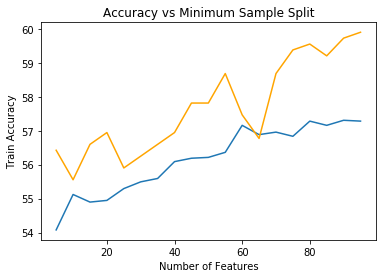

In [52]:
optimal_trainn = hyperparams[train_results.index(max(train_results))]
optimal_testn = hyperparams[test_results.index(max(test_results))]
print "The optimal number is %d with %0.1f%%" %(optimal_trainn,max(train_results))
print "The optimal number is %d with %0.1f%%" %(optimal_testn,max(test_results))

plt.plot(hyperparams, train_results)
plt.plot(hyperparams, test_results, 'orange')
#plt.plot(hyperparams, train_results, hyperparams, test_results)
plt.xlabel('Number of Features')
plt.ylabel('Train Accuracy')
plt.title('Accuracy vs {}'.format('Minimum Sample Split'))

# Determine feature importance


In [62]:
importances = clf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print indices

[69 61 55 70  7 50 71 51 57 47 18  5 21 22 68 58 27 54 11  3 44 53  0 20 64
  1 10 12 29 19  8  2 63 52 65 35 46 45 56 48 23 41 49 14 34 66 62 42 26 60
 25 59 28  6 67 43 40 33 24 32 37 38 13 30 16 36 31 39  9 15  4 17]


Feature Ranking:
1. feature 69 {0.027023}
2. feature 61 {0.023410}
3. feature 55 {0.020849}
4. feature 70 {0.020732}
5. feature 7 {0.020286}
6. feature 50 {0.019699}
7. feature 71 {0.019624}
8. feature 51 {0.019295}
9. feature 57 {0.018758}
10. feature 47 {0.018690}
11. feature 18 {0.018419}
12. feature 5 {0.018130}
13. feature 21 {0.018049}
14. feature 22 {0.017612}
15. feature 68 {0.017388}
16. feature 58 {0.017282}
17. feature 27 {0.017143}
18. feature 54 {0.016921}
19. feature 11 {0.016857}
20. feature 3 {0.016610}
21. feature 44 {0.016605}
22. feature 53 {0.016402}
23. feature 0 {0.016181}
24. feature 20 {0.016076}
25. feature 64 {0.015928}
26. feature 1 {0.015596}
27. feature 10 {0.015137}
28. feature 12 {0.015133}
29. feature 29 {0.015088}
30. feature 19 {0.015029}
31. feature 8 {0.014877}
32. feature 2 {0.014649}
33. feature 63 {0.014638}
34. feature 52 {0.014482}
35. feature 65 {0.014436}
36. feature 35 {0.014426}
37. feature 46 {0.014333}
38. feature 45 {0.014264}
39. feature

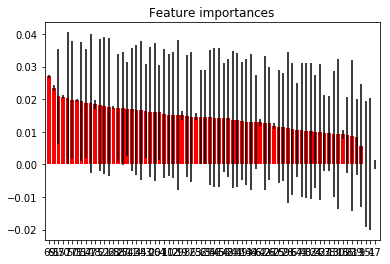

In [63]:
print("Feature Ranking:")

for f in range(trainFeatures.shape[1]):
    print("%d. feature %d {%f}" %(f+1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(trainFeatures.shape[1]), importances[indices], color="r", yerr=std[indices/4], align='center')
plt.xticks(range(trainFeatures.shape[1]), indices)
plt.xlim([-1, trainFeatures.shape[1]])
plt.show()

# Select most important features

In [95]:
sfm = SelectFromModel(clf1, threshold=0.010)
sfm.fit(trainFeatures, train['lbls'])

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=19, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=301, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.01)

In [96]:
important_indices = np.argsort(sfm.get_support(indices=True))[::-1]
print indices
for f in range(len(important_indices)):
    print "%d. Feature %d {%f}" %(f+1,indices[f], importances[indices[f]])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
1. Feature 0 {0.016181}
2. Feature 1 {0.015596}
3. Feature 2 {0.014649}
4. Feature 3 {0.016610}
5. Feature 4 {0.000133}
6. Feature 5 {0.018130}
7. Feature 6 {0.010700}
8. Feature 7 {0.020286}
9. Feature 8 {0.014877}
10. Feature 9 {0.005694}
11. Feature 10 {0.015137}
12. Feature 11 {0.016857}
13. Feature 12 {0.015133}
14. Feature 13 {0.009408}
15. Feature 14 {0.013062}
16. Feature 15 {0.000140}
17. Feature 16 {0.009190}
18. Feature 17 {0.000034}
19. Feature 18 {0.018419}
20. Feature 19 {0.015029}
21. Feature 20 {0.016076}
22. Feature 21 {0.018049}
23. Feature 22 {0.017612}
24. Feature 23 {0.013742}
25. Feature 24 {0.010055}
26. Feature 25 {0.011503}
27. Feature 26 {0.012582}
28. Feature 27 {0.017143}
29. Feature 28 {0.011276}
30. Feature 29 {0.015088}


IndexError: index 30 is out of bounds for axis 0 with size 30

In [97]:
X_important_train = sfm.transform(trainFeatures)
X_important_test = sfm.transform(valFeatures)

In [98]:
clf_important = RandomForestClassifier (n_estimators=301, max_depth=7, max_features=19, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, train['lbls'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=19, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=301, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [99]:
preds = clf_important.predict(X_important_test)
gtruth = np.array(val['lbls'])
totalAccu = np.equal(preds,gtruth).mean()*100
errorRate = (preds != gtruth).mean() * 100
num_class = 2
# Create array for confusion matrix with dimensions based on number of classes
confusion_matrix_rawcount = np.zeros ((num_class, num_class))
class_count = np.zeros((num_class,1)) # 1st col represents number of images per class

# Create confusion matrix
predClass = ['Predicted Copepods', 'Predicted Non-Copepods']
trueClass = ['True Copepods', 'True Non-Copepods']
for t, p in zip (gtruth, preds):
    class_count[t,0] += 1
    confusion_matrix_rawcount[t, p] += 1
df_rawcount = pd.DataFrame(confusion_matrix_rawcount, columns=predClass, index=trueClass)
confusion_matrix_rate = np.zeros((num_class,num_class))
for i in range(num_class):
    confusion_matrix_rate[i,:] = (confusion_matrix_rawcount[i,:])/class_count[i,0]*100
confusion_matrix_rate = np.around(confusion_matrix_rate, decimals=4)
df_rate = pd.DataFrame(confusion_matrix_rate, columns=predClass, index=trueClass)
print df_rate

# Normalized Accuracy
normAccu = (confusion_matrix_rate[0,0]+confusion_matrix_rate[1,1])/2.00
#print("Normalized Accuracy: {}".format(normAccu))

# Normalized Error Rate
normError = 100.00 - normAccu

print("Accuracy: {}, Error: {}".format(totalAccu,errorRate))
print("Normalized Accuracy: {}, Normalized Error: {}".format(normAccu,normError))

                   Predicted Copepods  Predicted Non-Copepods
True Copepods                  2.5532                 97.4468
True Non-Copepods              1.7595                 98.2405
Accuracy: 59.2013888889, Error: 40.7986111111
Normalized Accuracy: 50.39685, Normalized Error: 49.60315
